In [1]:
import torch
import torchvision
import numpy as np
from PIL import Image
import json
import numpy as np 
import math
import matplotlib.pyplot as plt 
import os

json_path = './annotations/mpii/fullannotations.json'
joint_path = './annotations/mpii/jointdict.json'
histogram_path = './annotations/mpii/histogram.json'
images_path = './images/mpii_resized'
mapp_path = './images/mpii_map'

with open(json_path, 'r') as fp:
    json_list = json.load(fp)

with open(joint_path, 'r') as fp:
    joint_dict = json.load(fp)

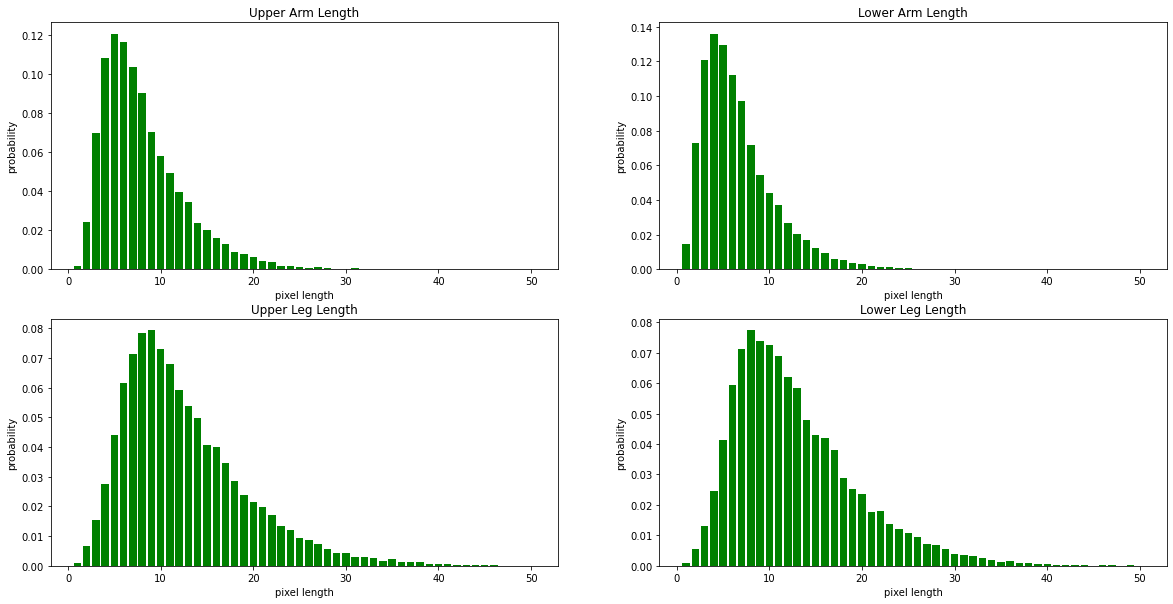

In [2]:
def visualize_histogram(histogram_path, end = 50, grid = (2, 2)):
    
    def plot(i, histogram, title, color, norm=True):
        histogram = np.array(histogram)
        if norm:
            histogram = histogram / np.sum(histogram)
        
        plt.subplot(*grid, i)
        plt.bar(range(1, end+1), histogram, color=color)
        plt.title(title)
        plt.ylabel('probability')
        plt.xlabel('pixel length')
    
    with open(histogram_path, 'r') as fp:
        joint_histogram = json.load(fp)

    plt.figure(figsize=(20, 10))
    
    plot(1, joint_histogram['u_arm'][:end], 'Upper Arm Length', 'g')
    plot(2, joint_histogram['l_arm'][:end], 'Lower Arm Length', 'g')
    plot(3, joint_histogram['u_leg'][:end], 'Upper Leg Length', 'g')
    plot(4, joint_histogram['l_leg'][:end], 'Lower Leg Length', 'g')
    plt.show()

visualize_histogram(histogram_path)

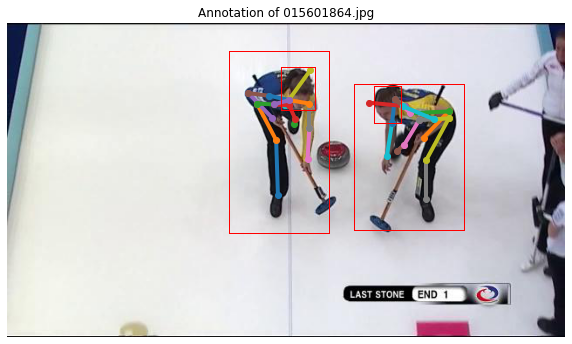

In [3]:
def plot_line(coor1, coor2, marker='o', linewidth=4, color=None):
    if coor1 and coor2: 
        x1, y1 = coor1
        x2, y2 = coor2
        plt.plot([x1, x2], [y1, y2], marker=marker, linewidth=linewidth, color=color)
        
def plot_rect(x1, y1, x2, y2):
    plot_line((x1, y1), (x1, y2), '', 1, 'r')
    plot_line((x1, y2), (x2, y2), '', 1, 'r')
    plot_line((x2, y2), (x2, y1), '', 1, 'r')
    plot_line((x2, y1), (x1, y1), '', 1, 'r')

def get_joint(joint_id, joint_list):
    for joint in joint_list:
        if joint['id'] == joint_id: return joint
    return None

def find(joint_list, lambda_fn):
    _ss = joint_list[0]
    for e in joint_list:
        if not lambda_fn(e, _ss): continue
        _ss = e
    return _ss

def head_width(head_c):
    width = abs(head_c['x1'] - head_c['x2']) 
    height = abs(head_c['y1'] - head_c['y2'])
    return (width + height) // 4

def draw_person_rect(joint_list, head_coor, image_shape):
    c = head_width(head_coor)
    
    minx = find(joint_list, lambda c, e: c['x'] < e['x'])['x']
    maxx = find(joint_list, lambda c, e: c['x'] > e['x'])['x']
    miny = find(joint_list, lambda c, e: c['y'] < e['y'])['y']
    maxy = find(joint_list, lambda c, e: c['y'] > e['y'])['y']
    
#     print(minx, miny, maxx, maxy)
    
    plot_rect(max(minx - c, 0), 
              max(miny - c, 0), 
              min(maxx + c, image_shape['width']), 
              min(maxy + 2*c, image_shape['height']))
            
        
def present_body_parts(image_array, image_object, joint_dict, title, draw_head=True, draw_bbox=False, draw_pose=True):
    plt.figure(figsize=(10, 20))
    plt.axis('off')
    plt.imshow(image_array)
    plt.title(title)

    for person in image_object['people']:
        joint_list = person['joints']
        joint_map = {}
        for k in joint_dict:
            joint_temp = get_joint(joint_dict[k], joint_list)
            if not joint_temp: 
                joint_map[k] = None
            else:
                joint_map[k] = (joint_temp['x'], joint_temp['y'])
        if draw_pose:
            # legs
            plot_line(joint_map['r_ankle'], joint_map['r_knee'])
            plot_line(joint_map['r_knee'], joint_map['r_hip'])
            plot_line(joint_map['l_ankle'], joint_map['l_knee'])
            plot_line(joint_map['l_knee'], joint_map['l_hip'])
            # arms
            plot_line(joint_map['r_wrist'], joint_map['r_elbow'])
            plot_line(joint_map['r_elbow'], joint_map['r_shoulder'])
            plot_line(joint_map['l_wrist'], joint_map['l_elbow'])
            plot_line(joint_map['l_elbow'], joint_map['l_shoulder'])
            # head
            plot_line(joint_map['upper_neck'], joint_map['head_top'])
            plot_line(joint_map['upper_neck'], joint_map['thorax'])
            # body
            plot_line(joint_map['r_shoulder'], joint_map['thorax'])
            plot_line(joint_map['l_shoulder'], joint_map['thorax'])
            plot_line(joint_map['r_hip'], joint_map['pelvis'])
            plot_line(joint_map['l_hip'], joint_map['pelvis'])
            plot_line(joint_map['thorax'], joint_map['pelvis'])
        
#         if not 'head_coordinates' in person: continue
            
        person_head = person['head_coordinates']
        x1 = person_head['x1']
        y1 = person_head['y1']
        x2 = person_head['x2']
        y2 = person_head['y2']
        
        if draw_head:
            plot_rect(x1, y1, x2, y2) # draw head
        
        if draw_bbox:
            draw_person_rect(joint_list, person_head, image_object['image_shape']) # draw body
        
    
    plt.show()
    
def show_image(image_object, images_path):
    image_name = image_object['image_name']
    image_array = np.array(Image.open(os.path.join(images_path, image_name)))
    
    present_body_parts(image_array, image_object, joint_dict, f'Annotation of {image_name}',\
                      draw_head=True, draw_bbox=True, draw_pose=True)

#     print(json.dumps(image_object, indent=1))

show_image(json_list[0], images_path)

In [6]:
a = [382433, 137705, 33244, 15154, 431915, 245380, 73805, 31584, 137638, 2084869, 421549, 401523, 315353, 834847, 247942, 463656, 1081158, 3220900, 374904, 1050012, 271686, 223548, 470417, 320084, 1251799, 289718, 303685, 79938, 51581, 12193, 32161, 124762, 270887, 86329, 12147, 3320, 77469, 29326, 70784, 24939, 257541, 77469, 231732, 1178664, 486917, 309978, 187595, 2869873, 367502, 156557, 121762, 70869, 36294, 22036, 8733, 31299, 45478, 158817, 266007, 34972, 8997, 32598, 13006, 1662242, 217573, 2167478, 141827, 52719, 101850, 1517974, 616322, 172060, 9069, 9601, 8074, 185312, 869081, 805827, 28981, 50141, 195028, 108007, 172678, 252573, 70487, 146843, 180346, 173644, 59577, 96729, 34493, 12258, 10567, 8223, 259219, 141053, 319045, 34418, 707189, 348716, 830012, 174086, 61195, 183290, 31299, 13186, 63370, 319562, 7986, 13095, 2712, 446335, 594707, 59770, 8526, 478537, 241839, 93890, 46932, 94145, 56488, 40218, 45003, 69902, 88422, 55420, 177911, 32149, 235166, 98276, 89555, 99504, 91165, 194368, 68495, 8558, 8872, 33635, 198539, 139334, 10084, 425352, 46482, 171767, 34775, 46726, 21166, 212253, 37409, 27666, 15111, 12763, 5455, 70702, 28896, 223063, 162776, 249007, 210804, 2391694, 6866, 13120, 36999, 533748, 246767, 75104, 8414, 6442, 47765, 365516, 106400, 38282, 10084, 7108, 5968, 26217, 30315, 7567, 87822, 20505, 209149, 201874, 26033, 6587, 2730, 12203, 82602, 46965, 83568, 43073, 17396, 58177, 15167, 7834, 5179, 12826, 26087, 24001, 435327, 49566, 102752, 402586, 1347229, 169009, 95773, 81843, 171993, 2010453, 130848, 14642, 4562, 38270, 4551, 7889, 9017, 8213, 5941, 44185, 78092, 87915, 6357, 4229, 6050, 11874, 41498, 103302, 34282, 146577, 186880, 162879, 332910, 469636, 30395, 153928, 284530, 50598, 238698, 403241, 693185, 2010713, 207962, 1320686, 372090, 553399, 78531, 153570, 194893, 145263, 30715, 21706, 5710, 7798, 2675, 565783, 402389, 129949, 134015, 63098, 36551, 52680, 18085, 39053, 136358, 81374, 107439, 97972, 102724, 326274, 84440, 18576, 7871, 142983, 177039, 674447, 39678, 61558, 197676, 106929, 97492, 44499, 16905, 6433, 4454, 3623, 68941, 41042, 99610, 97416, 78214, 43020, 32006, 29326, 779514, 46384, 161227, 98401, 17094, 8872, 15046, 5163, 5417, 5439, 139317, 62002, 161053, 16734, 50231, 237690, 1531292, 160892, 168008, 68241, 13903, 150488, 479218, 19961, 21596, 142167, 89798, 31981, 71370, 58732, 12849, 17684, 7047, 35864, 69169, 86836, 172366, 312964, 210266, 391016, 99189, 96711, 236007, 234928, 1668, 63482, 131616, 59686, 7322, 5305, 9384, 20210, 192981, 15962, 655331, 194996, 93074, 21790, 55019, 41243, 62299, 27456, 44621, 28886, 117739, 60198, 14259, 6702, 61664, 24228, 75561, 46053, 226546, 337942, 380288, 775742, 51227, 227460, 11241, 7611, 12173, 4544, 52058, 209283, 44261, 22842, 124871, 167753, 378552, 196290, 104418, 12003, 33543, 130572, 107927, 32713, 156161, 124124, 4805, 36301, 91720, 60330, 43348, 51293, 11856, 8647, 9431, 5556, 101147, 39717, 40917, 27928, 18783, 4813, 3751, 8045, 5985, 109007, 92351, 256683, 34688, 17268, 10866, 15796, 38968, 57482, 80156, 61441, 83042, 49344, 82964, 107175, 251087, 92311, 168050, 10086, 3762, 6028, 21674, 10988, 405988, 383653, 2425079, 144247, 387650, 702430, 27828, 166484, 139962, 41169, 175231, 345140, 46605, 132006, 32706, 185262, 36964, 14037, 235074, 18412, 55676, 240413, 23988, 4869, 16193, 25903, 137062, 54284, 172441, 13260, 8259, 4639, 8646, 6636, 88369, 108003, 65494, 248533, 250375, 10920, 258236, 526599, 366318, 10016, 15661, 4860, 14283, 34299, 355064, 120240, 31940, 98856, 99489, 105688, 964687, 1163544, 131284, 556414, 386469, 315102, 1559798, 6680, 15237, 3896, 49145, 11766, 119414, 30468, 1678844, 357109, 726385, 1096234, 794584, 516865, 122779, 56049, 502527, 137277, 714667, 1118925, 1879248, 47220, 10604, 9627, 119784, 37612, 54401, 506990, 3023031, 340304, 226360, 71023, 105351, 392623, 159141, 117405, 186780, 99744, 2010459, 84365, 8786, 5222, 5212, 86521, 22120, 48465, 67997, 60144, 122910, 487598, 350254, 144009, 87793, 602561, 446132, 917350, 50905, 92517, 47910, 36277, 137225, 39109, 177597, 75038, 178074, 124251, 151353, 246442, 188063, 555672, 93854, 14152, 9373, 23236, 8372, 10410, 15416, 41569, 241436, 31424, 57697, 182482, 3505, 15838, 27850, 59568, 21441, 11791, 7625, 79986, 24174, 69782, 55992, 8498, 23925, 129133, 95974, 363263, 1627978, 238127, 327201, 136509, 8610, 6469, 40616, 81187, 118913, 410140, 673977, 18471, 23816, 971891, 687995, 719854, 1053326, 847829, 413408, 18122, 119067, 43927, 9560, 8516, 11382, 10225, 5353, 6209, 5587, 28483, 370876, 133316, 277277, 111475, 492581, 3888, 5905, 8111, 23975, 10576, 276107, 458108, 108296, 50407, 80141, 2060716, 26737, 112369, 114727, 88859, 52642, 49646, 54598, 45851, 26679, 31090, 24487, 6315, 38912, 60417, 84152, 95899, 24307, 7831, 4319, 7812, 4349, 62482, 46932, 38217, 48921, 11355, 23564, 138611, 9306, 6784, 91193, 34324, 11423, 22581, 57384, 326717, 1046794, 627211, 1145419, 339727, 261224, 211972, 429401, 167603, 151873, 1083082, 12743, 7565, 121542, 13768, 64847, 33986, 809915, 51373, 5495, 8012, 12667, 84401, 81561, 38135, 63364, 239475, 1698808, 79688, 144450, 35591, 155452, 165662, 224638, 771228, 924603, 463521, 348653, 157158, 87432, 21188, 8040, 20354, 50393, 208125, 49422, 214005, 84693, 155285, 220281, 57747, 5867, 32609, 4748, 3835, 227113, 54758, 23486, 153447, 127275, 174598, 128135, 7892, 2965, 82851, 194869, 6261, 11263, 12211, 3404, 17136, 74075, 572, 237418, 119500, 28696, 5554, 6766, 8490, 170271, 579625, 1709197, 887141, 1331344, 54862, 31253, 549867, 191143, 182419, 41554, 144015, 226965, 330156, 570802, 1498911, 11428, 56816, 2863, 5809, 3702, 62328, 37687, 61213, 12882, 2007, 4010, 1906, 1246433, 375649, 276441, 351582, 13837, 3836, 9075, 10038, 25963, 321222, 114327, 60317, 218992, 37509, 14051, 450682, 316068, 12074, 15444, 5653, 228270, 2742693, 378299, 178633, 37611, 16846, 10363, 54223, 45058, 10201, 31000, 217097, 38497, 5870, 2996, 8226, 29365, 62051, 8922, 15921, 45552, 40616, 554198, 432535, 8736, 5492, 17255, 7548, 10954, 24422, 58141, 62781, 181927, 34573, 947303, 594302, 181752, 31362, 1659353, 1633191, 271877, 43513, 70670, 80319, 79644, 281382, 244856, 2001691, 153731, 534284, 76558, 8400, 2254, 188580, 48857, 67663, 27003, 35760, 130596, 97130, 47573, 40483, 22025, 10378, 67242, 163090, 243855, 5143, 18631, 3687, 4084, 91388, 71874, 24940, 79865, 81831, 33682, 1282746, 488333, 143136, 78388, 83773, 37769, 175553, 336525, 675699, 30146, 56518, 62643, 15710, 50261, 31596, 7903, 3432, 137455, 122126, 6781, 12177, 71555, 92291, 13711, 313607, 15028, 2112, 5761, 53849, 154253, 195246, 97898, 39737, 66771, 16682, 180434, 47090, 55458, 77814, 58597, 27968, 91820, 90812, 10726, 2949, 8199, 1759, 155809, 49971, 28819, 22033, 33385, 892568, 430036, 33474, 44678, 135492, 4632, 8325, 7137, 8539, 71200, 85776, 472383, 159747, 499361, 1078790, 1149017, 36939, 69596, 172549, 62786, 73416, 26583, 11825, 92401, 60800, 86671, 58613, 46258, 2307291, 1308155, 507247, 15172, 27319, 7171, 8826, 58829, 302080, 141210, 101372, 45474, 154700, 60946, 20470, 490260, 44942, 76163, 152764, 8980, 2050, 9552, 2006625, 134716, 356959, 223741, 118717, 64176, 20696, 104207, 111490, 86117, 122284, 209263, 2674, 15141, 3915, 44612, 96858, 37632, 31840, 2885, 6461, 20923, 25217, 173069, 48037, 164052, 80564, 53937, 51639, 68968, 29653, 44933, 114927, 224676, 290954, 3494, 63510, 140654, 122577, 18968, 53321, 607533, 1063336, 8915, 3258, 16129, 4965, 29068, 34015, 105577, 83689, 16897, 89867, 29932, 191927, 125282, 11157, 2261877, 283619, 53534, 45334, 223833, 34864, 33453, 116916, 175112, 233150, 160358, 50155, 447878, 298201, 1375640, 127929, 39418, 232255, 303260, 398636, 547987, 173709, 75071, 8234, 21776, 487315, 2578611, 279549, 52372, 56521, 36000, 87297, 44100, 45763, 99555, 64766, 26782, 20327, 7451, 14197, 40116, 65020, 23896, 209481, 197033, 182700, 118042, 2401, 22294, 19972, 5749, 22976, 25327, 17207, 11015, 6151, 486173, 1021610, 241415, 122852, 236288, 56021, 55758, 182557, 57847, 287962, 135784, 10097, 15053, 54842, 149561, 135534, 200323, 19750, 2038, 11515, 3798, 993544, 467682, 420591, 41072, 125707, 414463, 8566, 6335, 70416, 406310, 1821970, 167596, 27409, 47208, 567771, 1432035, 144143, 97988, 360484, 358371, 8499, 3142, 482077, 1570965, 8331, 6934, 30176, 49416, 89554, 247885, 87444, 122188, 9276, 6156, 221571, 52878, 28329, 497626, 202888, 230226, 298405, 391724, 583695, 138720, 18446, 48161, 56588, 83904, 137457, 57130, 48164, 45069, 49405, 120839, 120395, 33644, 44886, 62260, 56540, 39745, 27779, 65627, 36961, 10501, 6811, 40959, 100037, 130162, 153271, 151049, 187833, 10742, 16425, 3139, 178166, 377043, 5854, 3026, 7157, 6543, 79022, 69358, 44779, 9786, 12982, 27033, 280969, 1365177, 198682, 58360, 218932, 272126, 119921, 84721, 141233, 24205, 172196, 183775, 44940, 500324, 5711, 7594, 41826, 96774, 65020, 27430, 30934, 136923, 242499, 62786, 624623, 335793, 182420, 76726, 35881, 306324, 126545, 34479, 193029, 97883, 89881, 54824, 7513, 6081, 3261, 115419, 30295, 207306, 417576, 1473442, 1308308, 13482, 42284, 134352, 173203, 204430, 302891, 2379223, 190889, 573765, 34839, 76008, 94097, 64898, 56589, 152054, 186850, 133432, 33973, 34860, 366754, 342620, 6042, 14488, 5923, 4826, 303690, 77104, 113075, 78677, 136259, 289143, 691133, 1145939, 143643, 200041, 937111, 984127, 35131, 18046, 41597, 174558, 2718147, 83534, 29704, 19677, 39016, 75919, 98096, 54788, 366174, 136154, 193156, 110945, 37731, 28347, 225426, 196194, 6577, 2580, 86918, 75222, 30327, 273710, 10067, 34181, 34534, 309668, 486516, 173274, 36182, 143938, 81043, 76819, 63060, 24165, 299905, 229858, 81947, 141798, 443038, 42613, 58354, 45356, 165300, 888703, 8153, 6365, 10166, 7886, 4431, 665726, 133966, 9643, 6238, 7836, 6295, 196070, 24940, 157910, 14317, 226269, 338970, 455212, 669168, 1194316, 178276, 95970, 31959, 232630, 1765541, 68231, 52376, 43323, 22138, 15082, 112264, 34150, 661384, 171305, 10382, 25669, 193925, 42026, 50939, 67567, 10503, 13870, 41140, 12033, 39880, 34571, 146391, 74460, 103993, 171164, 590431, 803651, 184685, 165908, 118903, 90133, 77612, 37287, 14169, 52055, 8850, 32031, 122354, 8795, 47758, 186068, 38454, 47075, 158687, 32322, 117330, 28047, 34146, 85205, 11768, 7646, 2709, 9313, 2691, 16069, 107962, 122694, 53135, 209281, 229405, 123377, 12628, 11603, 89465, 186234, 11083, 6955, 9181, 144275, 36134, 23970, 59834, 43810, 56948, 5532, 20704, 406165, 34479, 324686, 149247, 57473, 141124, 59097, 121785, 187194, 356983, 885024, 291045, 159795, 142155, 39687, 93880, 80546, 33655, 45997, 4131, 5927, 8367, 32882, 83316, 776124, 2727603, 231410, 187311, 19863, 1868, 26744, 71749, 10674, 43633, 7467, 182460, 201675, 14209, 31925, 5947, 57123, 189725, 176593, 4973, 5286, 17305, 90394, 183120, 422109, 238637, 397822, 318172, 144317, 283440, 9287, 17365, 4614, 4537, 1562736, 97398, 74154, 57389, 48480, 56220, 65881, 27636, 42014, 37828, 18711, 125896, 48445, 9353, 15244, 182212, 252962, 303538, 630087, 5288, 3456, 4460, 4590, 25624, 8433, 118084, 134400, 57781, 44403, 84138, 41023, 38086, 31788, 349441, 6607, 32485, 1135090, 356071, 98378, 180008, 43900, 10176, 8295, 7734, 9356, 58097, 48973, 120793, 145620, 40517, 11779, 29196, 41425, 52360, 37949, 80316, 128859, 49075, 10261, 304081, 112671, 15986, 195276, 81974, 375721, 88563, 1962289, 202894, 50068, 6574, 17386, 20036, 27453, 44120, 66751, 71350, 526876, 51935, 71884, 110449, 14254, 29213, 84771, 48942, 598801, 236631, 305467, 77580, 64448, 107145, 24849, 44698, 206514, 23841, 447007, 5441, 8974, 51674, 6393, 134349, 246222, 245860, 205109, 435063, 54557]

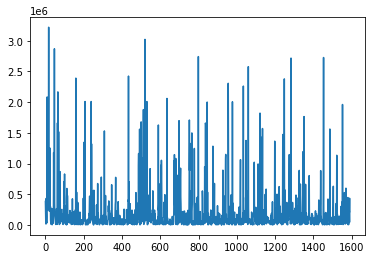

In [7]:
plt.plot(a)

In [ ]:
iou(json_list[52]['people'][0]['bbox'], json_list[52]['people'][1]['bbox'])

In [ ]:
import torch
from PIL import Image
import json

# Model
# model = torch.hub.load('ultralytics/yolov3', 'yolov3', pretrained=True).autoshape()  # for PIL/cv2/np inputs and NMS

# Images
# img1 = Image.open('zidane.jpg')

# Inference
# prediction = model(img1, size=640)  # includes NMS

In [ ]:
def run_yolo_on(image_object):
    image_name = image_object['image_name']
    image_pil = 

In [ ]:
json_list[52]['image_name']

In [12]:
max(['lol1.pt', 'lol2.pt', 'lol31.pt', 'lol23.pt'])

'lol31.pt'

In [13]:
from datetime import datetime



'2021-02-25 00:01:17.336920'

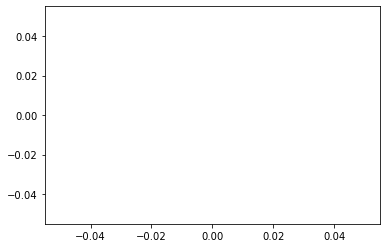

In [28]:
import torch
import matplotlib.pyplot as plt 

def to_list(loss_objects):
    return [e['loss'] for e in loss_objects]

status_quo = torch.load('./train/snapshot-0.pt')
plt.plot(to_list(status_quo['train_loss']))
plt.plot(to_list(status_quo['val_loss']))
plt.show()
